# Unfolding with Estimated Response Matrices

In this notebook, we provide a demmo performing unfolding task using different estimated response matrices. The goal is to show how the choice of the response matrix can affect the unfolding results.


## Load the libraries

```python

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import os

## Utility Functions

Functions for computing the point estimates for unfolded solution and plotting.

In [3]:
def cholesky_trans(y, smear_means, K):
    """
    Cholesky transformation of the data and kernel matrix

    :param y: data vector
    :param smear_means: means of the smeared histogram
    :param K: response matrix
    
    :return: transformed response matrix and data vector
    """
    # find the change in basis
    Sigma_data = np.diag(smear_means)
    L_data = np.linalg.cholesky(Sigma_data)
    L_data_inv = np.linalg.inv(L_data)
    # transform the matrix
    K_trans = L_data_inv @ K
    # transform the data
    y_trans = L_data_inv @ y
    return K_trans, y_trans

def generate_ls_point_estimators(y, smear_means, K):
    """
    Generate least squares point estimators.

    :param y: data vector
    :param smear_means: means of the smeared histogram
    :param K: response matrix

    :return: least squares point estimators
    """
    K_trans, y_trans = cholesky_trans(y, smear_means, K)
    return np.linalg.lstsq(K_trans, y_trans, rcond=-1)[0]


def generate_Tikhonov_point_estimators(y, smear_means, K, alpha=1.0):
    """
    Generate Tikhonov regression point estimators.

    :param y: data vector
    :param smear_means: means of the smeared histogram
    :param K: response matrix
    :param alpha: regularization parameter

    :return: Tikhonov point estimators
    """
    K_trans, y_trans = cholesky_trans(y, smear_means, K)
    clf = Ridge(alpha=alpha, fit_intercept=False, solver='svd')
    clf.fit(K_trans, y_trans)
    return clf.coef_

def generate_IBU_point_estimators(y, K, niter):
    """
    Generate Iterative Bayesian Unfolding point estimators.

    :param y: data vector
    :param K: response matrix
    :param niter: number of iterations

    :return: IBU point estimators
    """
    lambdat = np.full(K.shape[1], np.mean(y))
    for t in range(niter):
        norm_factor = np.sum(K, axis=0)
        denom = K @ lambdat
        lambdatplusone = lambdat / norm_factor * (np.transpose(K) @ (y / denom))
        lambdat = lambdatplusone
    return lambdat


In [22]:
def plot_soln(soln, true_hist, bins, legend, linestyles=None, 
              legend_loc='best', log=False, title=None, save_file=None):
    """
    Plot the solution.

    :param soln: solution histograms with different methods
    :param true_hist: true histogram
    :param bins: bin edges
    """
    bins_mid = (bins[1:] + bins[:-1]) / 2
    plt.rcParams.update({
        #'font.size': 18,            # Base font size for all text
        #'axes.titlesize': 20,       # Title of each subplot
        'axes.labelsize': 32,       # Axis labels
        'xtick.labelsize': 24,      # Tick label size for X-axis
        'ytick.labelsize': 24,      # Tick label size for Y-axis
        'legend.fontsize': 18,      # Legend font size
    })


    fig = plt.figure(figsize=(15,10))
    # set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # the first subplot
    ax0 = plt.subplot(gs[0])
    # log scale for axis Y of the first subplot
    if log:
        ax0.set_yscale("log")
    plt_label = legend
    ax0.bar(x=bins[:-1], height=true_hist, width=bins[1]-bins[0], align='edge', label="Truth", fill=False)
    for i in range(len(plt_label)):
        if i==0:
            ax0.plot(bins_mid, soln[0,:], linestyles[0], label=plt_label[0], linewidth=1, markersize=5)
        else:
            ax0.plot(bins_mid, soln[i,:], linestyles[i], label=plt_label[i], linewidth=1, markersize=5)
    if log:
        ax0.set_ylabel("Bin Count (log scale)")
    else:
        ax0.set_ylabel("Bin Count")


    # the second subplot
    # shared axis X
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.plot(bins_mid,np.ones(len(bins_mid)),color="skyblue")
    for i in range(len(plt_label)):
        if i==0:
            ax1.plot(bins_mid, soln[0,:]/true_hist, linestyles[0], label=plt_label[0], linewidth=1, markersize=5)
        else:
            ax1.plot(bins_mid, soln[i,:]/true_hist, linestyles[i], label=plt_label[i], linewidth=1, markersize=5)
    ax1.set_xlabel(r"$p_T$")
    ax1.set_ylabel("Ratio to Truth")
    plt.setp(ax0.get_xticklabels(), visible=False)

    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    # put legend on first subplot
    ax0.legend(loc=legend_loc)

    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)

    plt.suptitle(title, fontsize=32)

    if save_file is not None:
        plt.savefig(save_file, facecolor='w', transparent=False)

    plt.show()


## Simulated Inclusive Jets Data

In [5]:
files_mat = sorted(glob.glob("data/jet_pt/normal_kernel/response_matrices/*.csv"), key=os.path.getmtime)
files_x = glob.glob("data/jet_pt/normal_kernel/true_means/*.csv")
files_y = glob.glob("data/jet_pt/normal_kernel/smeared_histograms/*.csv")
files_mu = glob.glob("data/jet_pt/normal_kernel/smeared_means/*.csv")

In [6]:
response_mat = [pd.read_csv(file) for file in files_mat]
# true particle-level histogram mean (vectors of length 40)
x_hist = [pd.read_csv(file).to_numpy()[:,0] for file in files_x]
x_hist = x_hist[0]
# true detector-level histogram mean (vectors of length 40)
mu = [pd.read_csv(file).to_numpy()[:,0] for file in files_mu]
mu = mu[0]

KeyboardInterrupt: 

In [6]:
# Take the first 1000 detector-level histograms for computing the MAE
y_hist = [pd.read_csv(file).to_numpy()[:,0] for file in files_y[:1000]]

In [7]:
# binnings (ends) on the true space
xbins = np.linspace(start=400, stop=1000, num=len(x_hist)+1)
xbins_mid = (xbins[1:] + xbins[:-1]) / 2
    
# number of kernels
num_kernels = 5

In [8]:
# check the median condition numbers for each method based on 1000 estimated response matrices and 1 true response matrix
print("Median of the condition numbers for the response matrices:\n")
print("True matrix:\n", np.round(np.linalg.cond(response_mat[0])))
print("Location-scale:\n", np.round(np.median(np.linalg.cond(response_mat[1:1001]))))
print("Global kernel cde:\n", np.round(np.median(np.linalg.cond(response_mat[1001:2001]))))
print("Local kernel cde (d1=1, d2=1/400):\n", np.round(np.median(np.linalg.cond(response_mat[2001:3001]))))
print("Local Linear cde:\n", np.round(np.median(np.linalg.cond(response_mat[3001:4001]))))
print("Naive:\n", np.round(np.median(np.linalg.cond(response_mat[4001:5001]))))

Median of the condition numbers for the response matrices:

True matrix:
 1.318716047060091e+18
Location-scale:
 39383.0
Global kernel cde:
 39055198.0
Local kernel cde (d1=1, d2=1/400):
 151023054.0
Local Linear cde:
 6694.0
Naive:
 2576.0


### Plot the estimated respponse matrices and bin-wise MAE

Before computing the unfolded solution, first plot the estimated response matrices and the bin-wise mean absolute error (MAE) of the estimated response matrices with respect to the true response matrix. The MAE is computed as follows:

$$
MAE = \frac{1}{M} \sum_{l=1}^{M} |\hat{K}_{ij}^{(l)} - K_{ij}|
$$

where $\hat{K}_{ij}^{(l)}$ is the estimate of the $(i,j)^{th}$ bin in the $l^{th}$ simulation. The MAE is averaged over $M=1{,}000$ Monte Carlo simulations.

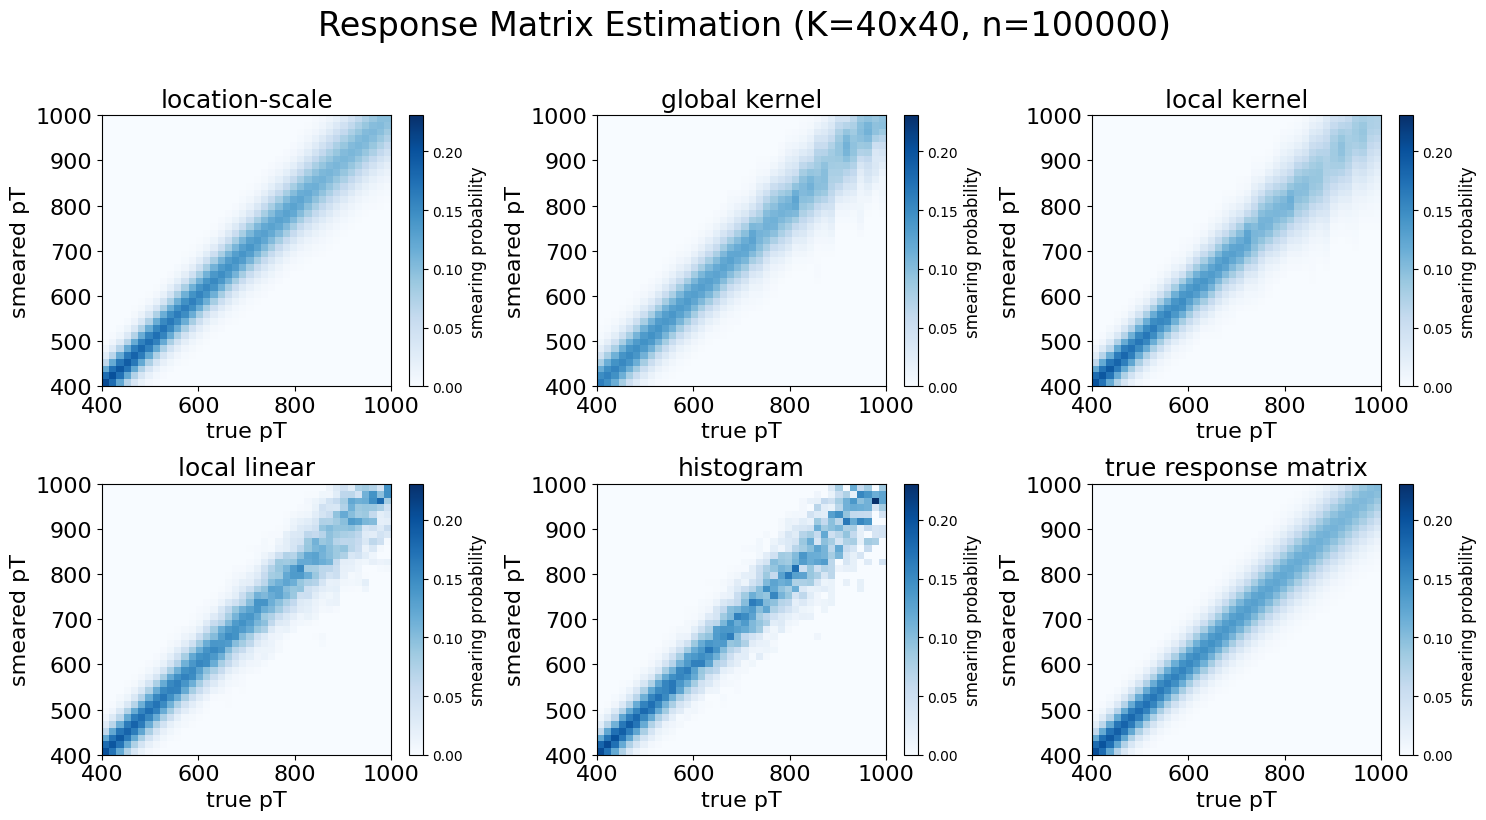

In [9]:
# indicate which Monte Carlo simulation to plot (1-1000)
mc_idx = 1
matrices = []
for i in range(num_kernels):
    matrices.append(response_mat[mc_idx + i * 1000])
matrices.append(response_mat[0])

methods = [
    "location-scale", 
    "global kernel", 
    "local kernel", 
    "local linear", 
    "histogram",
    "true response matrix"
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cbar_args = {'shrink': 1}
vmin = min(mat.min().min() for mat in matrices)
vmax = max(mat.max().max() for mat in matrices)

for ax, mat, title in zip(axes.flatten(), matrices, methods):
    im = ax.imshow(mat, extent=[400, 1000, 400, 1000], origin='lower', aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("true pT", fontsize=16)
    ax.set_ylabel("smeared pT", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    cbar = plt.colorbar(im, ax=ax, **cbar_args)
    cbar.set_label("smearing probability", fontsize=12)

plt.suptitle("Response Matrix Estimation (K=40x40, n=100000)", fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
# compute bin-wise MAE for each method
mae = []
for i in range(num_kernels):
    nrow, ncol = matrices[i].shape
    mae.append(np.zeros((nrow, ncol)))
    for j in range(1+i*1000, 1001+i*1000):
        # compute the MAE for each bin
        mae[i] += np.abs(response_mat[0] - response_mat[j]) / 1000

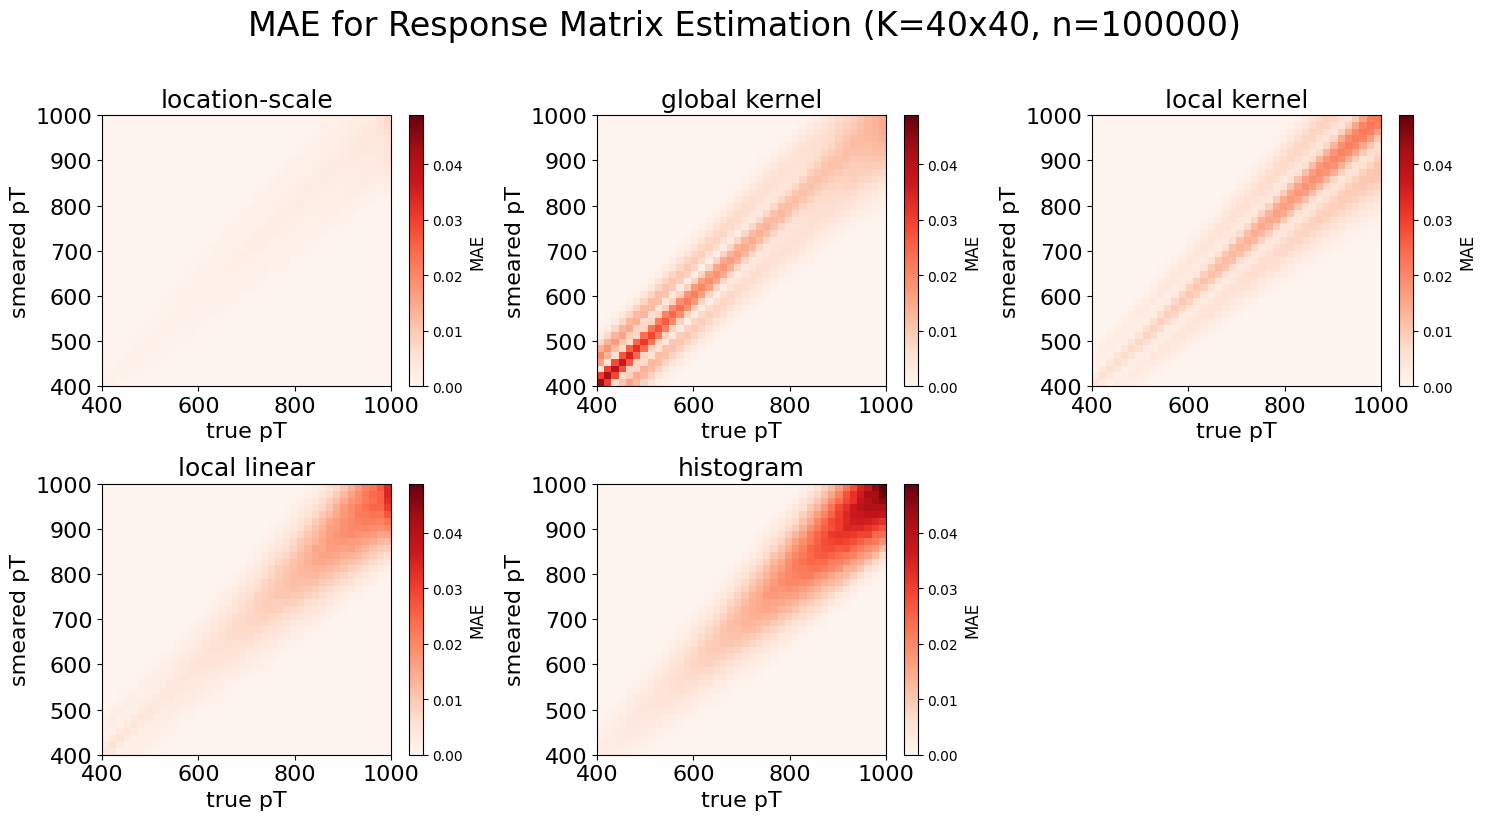

In [11]:
# plot the MAE heatmap
methods = [
    "location-scale", 
    "global kernel", 
    "local kernel", 
    "local linear", 
    "histogram"
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cbar_args = {'shrink': 1}
vmin = min(m.min().min() for m in mae)
vmax = max(m.max().max() for m in mae)

for ax, m, title in zip(axes.flatten(), mae, methods):
    im = ax.imshow(m, extent=[400, 1000, 400, 1000], origin='lower', aspect='auto', cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("true pT", fontsize=16)
    ax.set_ylabel("smeared pT", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    cbar = plt.colorbar(im, ax=ax, **cbar_args)
    cbar.set_label("MAE", fontsize=12)
axes[1,2].set_visible(False)

plt.suptitle("MAE for Response Matrix Estimation (K=40x40, n=100000)", fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

### Generate the stack of Tikhonov estimators

Changing the regularization parameter (alpha) can produce different estimates based on bias-variance trade-off.

In [86]:
# regularization parameter for Tikhonov regression
alpha = 0

Tikhonov_soln_stack = np.zeros(shape=(num_kernels+1,len(x_hist),len(y_hist)))
for i in range(Tikhonov_soln_stack.shape[0]):
    for k in range(Tikhonov_soln_stack.shape[2]):
        if i == 0:
            Tikhonov_soln_stack[i,:,k] = generate_Tikhonov_point_estimators(y_hist[k], mu, response_mat[0], alpha=alpha)
        else:
            Tikhonov_soln_stack[i,:,k] = generate_Tikhonov_point_estimators(y_hist[k], mu, response_mat[(i-1)*1000+k+1], alpha=alpha)
    print("Tikhonov solutions for kernel", i+1, "is done.")

Tikhonov solutions for kernel 1 is done.
Tikhonov solutions for kernel 2 is done.
Tikhonov solutions for kernel 3 is done.
Tikhonov solutions for kernel 4 is done.
Tikhonov solutions for kernel 5 is done.
Tikhonov solutions for kernel 6 is done.


### Generate the stack of IBU estimators

Changing the number of iterations (niter) can produce different estimates based on bias-variance trade-off.

In [80]:
# number of iterations for IBU
niter = 5000

IBU_soln_stack = np.zeros(shape=(num_kernels+1,len(x_hist),len(y_hist)))
for i in range(IBU_soln_stack.shape[0]):
    for k in range(IBU_soln_stack.shape[2]):
        if i == 0:
            IBU_soln_stack[i,:,k] = generate_IBU_point_estimators(y_hist[k], response_mat[0], niter=niter)
        else:
            IBU_soln_stack[i,:,k] = generate_IBU_point_estimators(y_hist[k], response_mat[(i-1)*1000+k+1], niter=niter)
    print("IBU solutions for kernel", i+1, "is done.")

IBU solutions for kernel 1 is done.
IBU solutions for kernel 2 is done.
IBU solutions for kernel 3 is done.
IBU solutions for kernel 4 is done.
IBU solutions for kernel 5 is done.
IBU solutions for kernel 6 is done.


### Plot the unfolded results

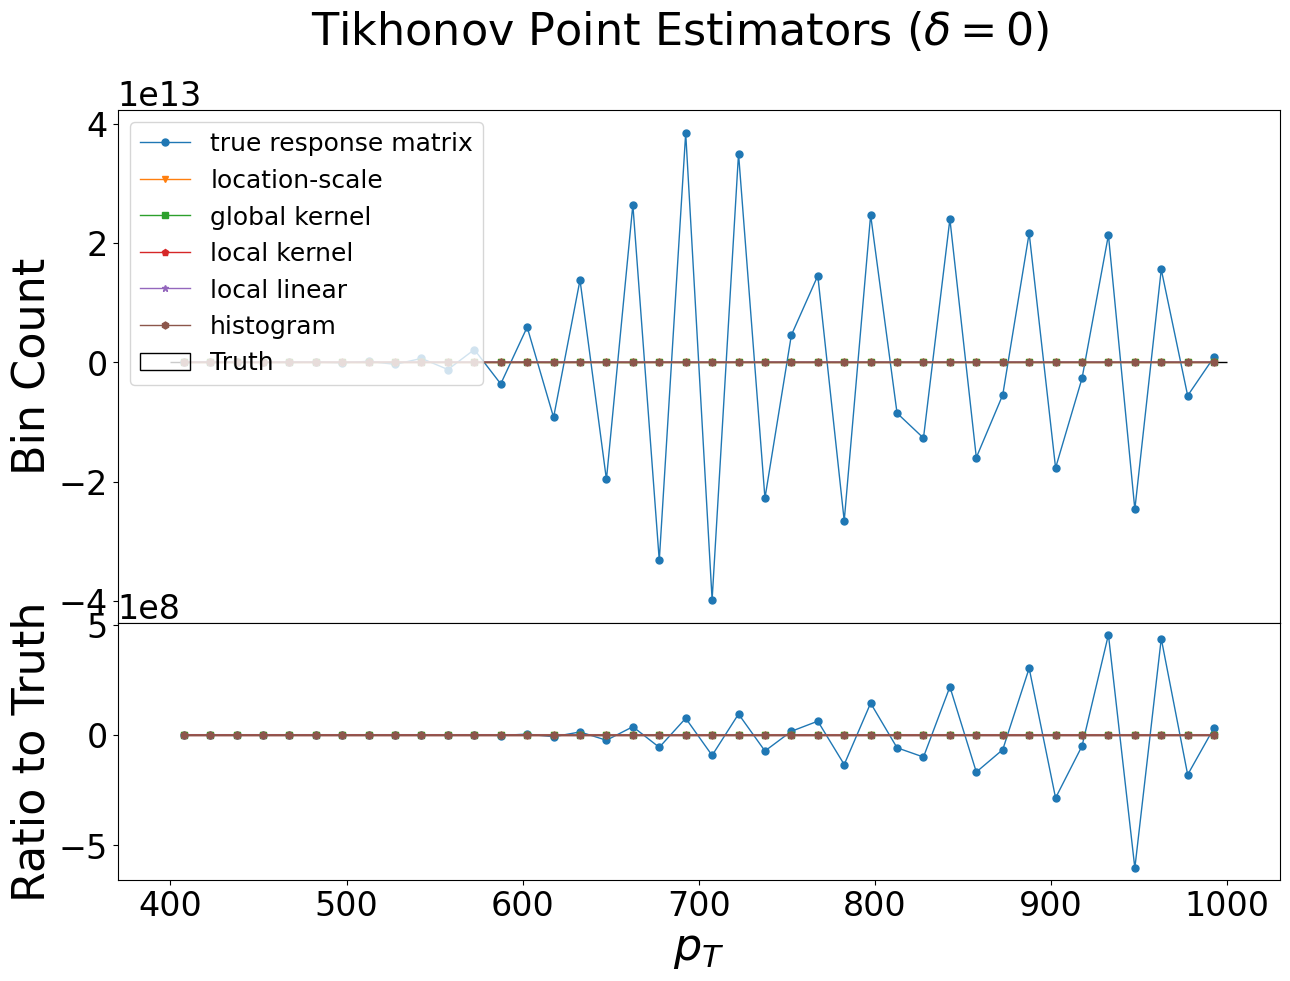

In [95]:
# choose the solution to plot
idx = 0
type = "Tikhonov"
#type = "IBU"
# choose whether to save the plot
save_plot = True


file_name = None
if type == "Tikhonov":
    soln = Tikhonov_soln_stack[:,:,idx]
    plot_title = rf"Tikhonov Point Estimators ($\delta={alpha}$)"
    if save_plot:
        file_name = rf"data/jet_pt/normal_kernel/results/Tikhonov_sol_alpha={alpha}.png"
else:
    soln = IBU_soln_stack[:,:,idx]
    plot_title = rf"IBU Point Estimators ($niter={niter}$)"
    if save_plot:
        file_name = rf"data/jet_pt/normal_kernel/results/IBU_sol_niter={niter}.png"


legend = ["true response matrix", "location-scale", "global kernel", "local kernel", 
                "local linear", "histogram"]
linestyles = ["-o","-v","-s","-p","-*","-h"]


plot_soln(soln, x_hist, xbins, legend, linestyles, title=plot_title, legend_loc='upper left',
          save_file=file_name)

### Plot MSE, bias, and variance

In [90]:
# select the solution to plot
type = "Tikhonov"
#type = "IBU"
if type == "Tikhonov":
    soln_stack = Tikhonov_soln_stack
elif type == "IBU":
    soln_stack = IBU_soln_stack

print("Bias, variance and MSE for", type, "estimators are computed.")


# compute the bias, variance and MSE
bias2 = np.zeros(shape=(num_kernels+1,len(x_hist)))
for i in range(bias2.shape[0]):
    bias2[i,:] = (np.mean(soln_stack[i,:,:],axis=1)-x_hist)**2
    
variance = np.zeros(shape=(num_kernels+1,len(x_hist)))
for i in range(variance.shape[0]):
    variance[i,:] = np.var(soln_stack[i,:,:],axis=1)

mse = np.zeros(shape=(num_kernels+1,len(x_hist)))
M = soln_stack.shape[2]
for i in range(mse.shape[0]):
    for k in range(M):
        mse[i,:] = mse[i,:] + 1/M * (x_hist-soln_stack[i,:,k])**2

Bias, variance and MSE for Tikhonov estimators are computed.


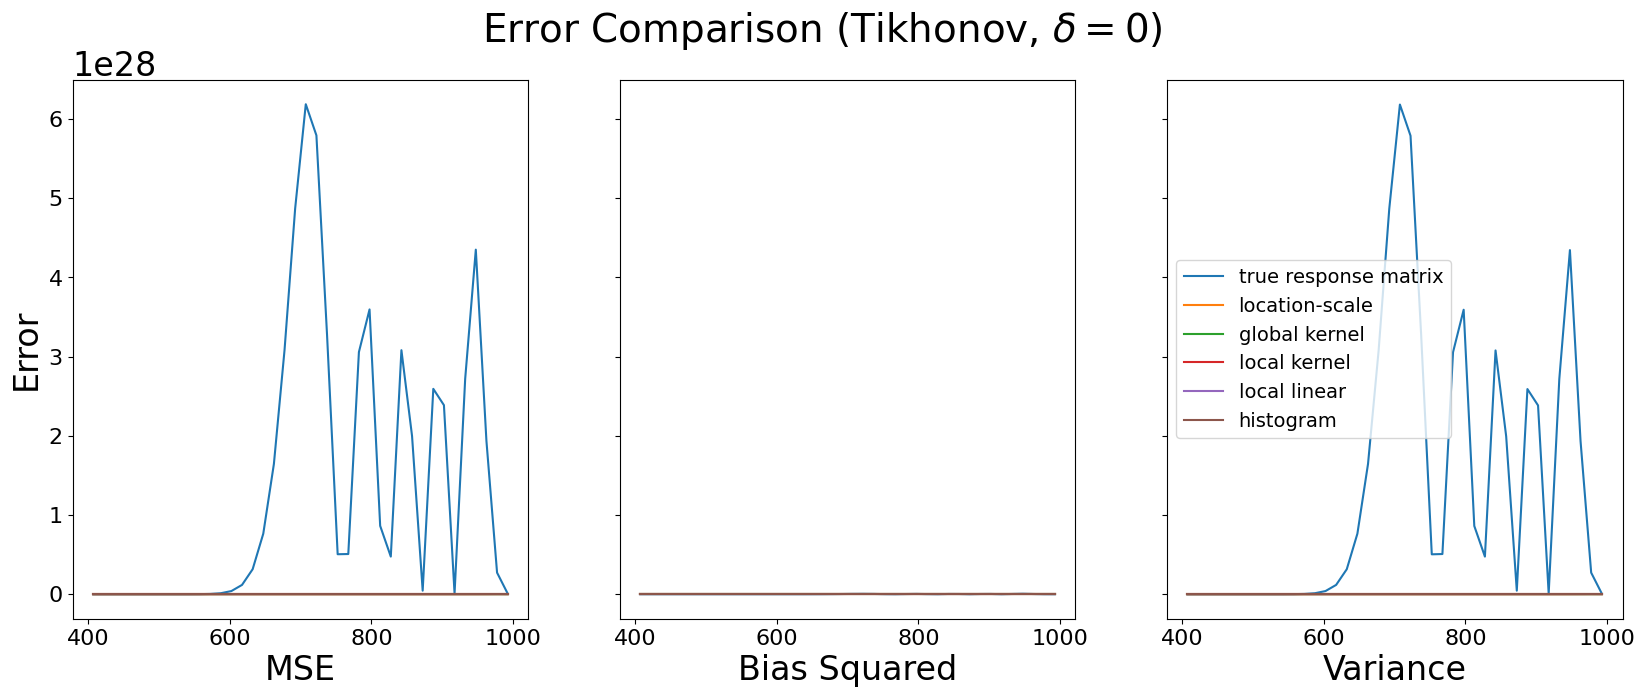

In [93]:
# set True if want to plot in log scale
log = False
# if saving the plot, set save_plot to True
save_plot = True

plt_label = ["true response matrix", "location-scale", "global kernel", "local kernel", 
             "local linear", "histogram"]
labels_size = 24


f, axarr = plt.subplots(1,3, sharey=True, figsize=(20, 7))
for i in range(mse.shape[0]):
    axarr[0].plot(xbins_mid,mse[i,:], label=plt_label[i])
    axarr[1].plot(xbins_mid,bias2[i,:], label=plt_label[i])
    axarr[2].plot(xbins_mid,variance[i,:], label=plt_label[i])
axarr[0].set_xlabel("MSE",fontsize=labels_size)
axarr[1].set_xlabel("Bias Squared",fontsize=labels_size)
axarr[2].set_xlabel("Variance",fontsize=labels_size)
axarr[0].set_ylabel("Error",fontsize=labels_size)
for ax in axarr:
    ax.tick_params(axis='both', which='major', labelsize=16)
if log:
    plt.yscale("log")
    axarr[0].set_ylabel("Error (log)",fontsize=labels_size)
    #plt.ylim(1,1e15)
plt.legend(loc='best', fontsize=14)
if type == "Tikhonov":
    f.suptitle(rf"Error Comparison ({type}, $\delta={alpha}$)", fontsize=28)
elif type == "IBU":
    f.suptitle(rf"Error Comparison ({type}, $niter={niter}$)", fontsize=28)


if save_plot:
    if type == "Tikhonov":
        file_name = rf'data/jet_pt/normal_kernel/results/mse_{type}_alpha={alpha}'
    elif type == "IBU":
        file_name = rf'data/jet_pt/normal_kernel/results/mse_{type}_niter={niter}'
    if log:
        file_name += "_log"
    file_name += ".png" 
    plt.savefig(file_name, facecolor='w', transparent=False)

plt.show()

## Drell-Yan Data

In [7]:
files_mat = sorted(glob.glob("data/Drell-Yan/response_matrices/*.csv"), key=os.path.getmtime)
files_x = glob.glob("data/Drell-Yan/true_histograms/*.csv")
files_y = glob.glob("data/Drell-Yan/smeared_histograms/*.csv")

In [8]:
response_mat = [pd.read_csv(file) for file in files_mat]
# particle-level histogram (vectors of length 40)
x_hist = [pd.read_csv(file).to_numpy()[:,0] for file in files_x]
x_hist = x_hist[0]
# detector-level histogram (vectors of length 40)
y_hist = [pd.read_csv(file).to_numpy()[:,0] for file in files_y]
y_hist = y_hist[0]

In [9]:
# binnings (ends) on the true space
xbins = np.linspace(start=20, stop=400, num=len(x_hist)+1)
xbins_mid = (xbins[1:] + xbins[:-1]) / 2
    
# number of kernels
num_kernels = 5

### Plot the estimated respponse matrices

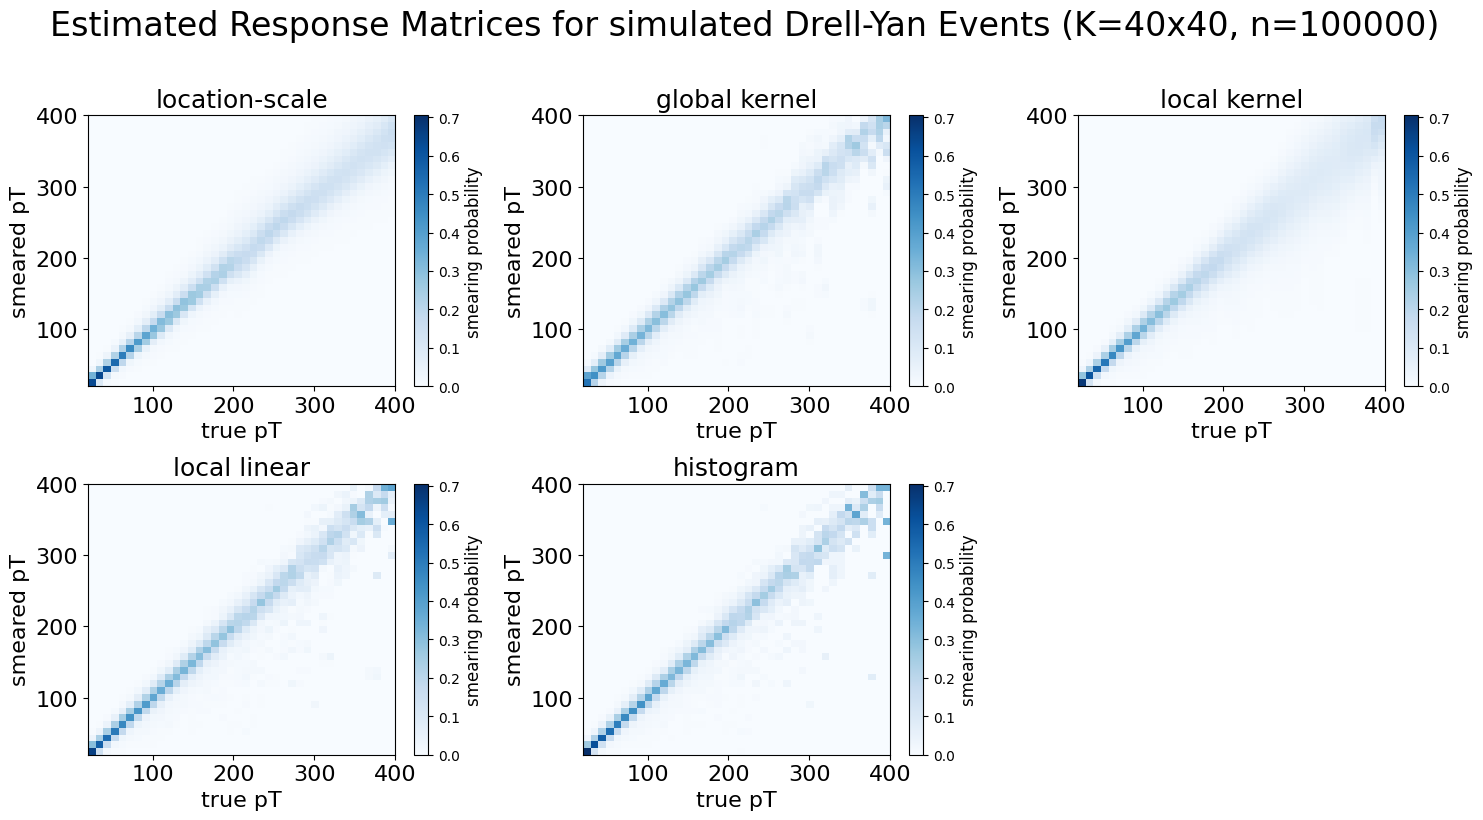

In [10]:
methods = [
    "location-scale", 
    "global kernel", 
    "local kernel", 
    "local linear", 
    "histogram"
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cbar_args = {'shrink': 1}
vmin = min(mat.min().min() for mat in response_mat)
vmax = max(mat.max().max() for mat in response_mat)

for ax, mat, title in zip(axes.flatten(), response_mat, methods):
    im = ax.imshow(mat, extent=[20, 400, 20, 400], origin='lower', aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("true pT", fontsize=16)
    ax.set_ylabel("smeared pT", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    cbar = plt.colorbar(im, ax=ax, **cbar_args)
    cbar.set_label("smearing probability", fontsize=12)
axes[1,2].set_visible(False)

plt.suptitle("Estimated Response Matrices for simulated Drell-Yan Events (K=40x40, n=100000)", fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
Tikhonov_soln = np.zeros(shape=(num_kernels,len(x_hist)))
# regularization parameter for Tikhonov solution
alpha = 1e-8

for i in range(Tikhonov_soln.shape[0]):
    Tikhonov_soln[i,:] = generate_Tikhonov_point_estimators(y_hist, y_hist, response_mat[i], alpha=alpha)


# number of iterations for IBU
niter = 5000

IBU_soln = np.zeros(shape=(num_kernels,len(x_hist)))
for i in range(IBU_soln.shape[0]):
    IBU_soln[i,:] = generate_IBU_point_estimators(y_hist, response_mat[i], niter=niter)

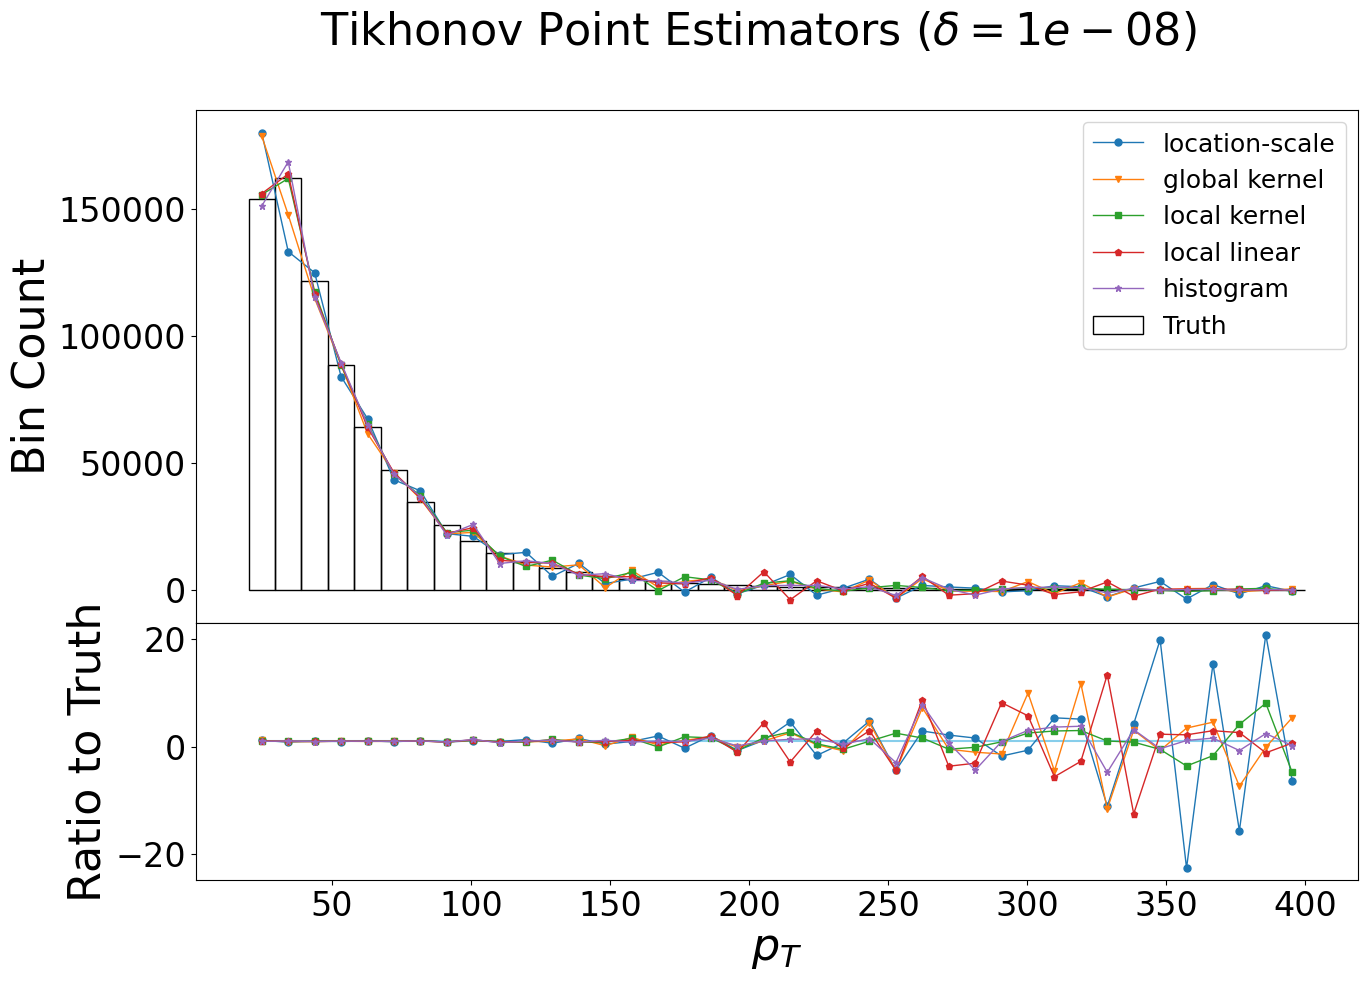

In [28]:
# choose the solution to plot
type = "Tikhonov"
#type = "IBU"
# choose whether to save the plot
save_plot = True


if type == "Tikhonov":
    soln = Tikhonov_soln
    plot_title = rf"Tikhonov Point Estimators ($\delta={alpha}$)"
    if save_plot:
        file_name = rf"data/Drell-Yan/results/Drell-Yan_Tikhonov_sol_alpha={alpha}.png"
elif type == "IBU":
    soln = IBU_soln
    plot_title = rf"IBU Point Estimators ($niter={niter}$)"
    if save_plot:
        file_name = rf"data/Drell-Yan/results/Drell-Yan_IBU_sol_niter={niter}.png"

legend = ["location-scale", "global kernel", "local kernel", 
                "local linear", "histogram"]
linestyles = ["-o","-v","-s","-p","-*"]

plot_soln(soln, x_hist, xbins, legend, linestyles, title=plot_title, save_file=file_name)